# AE를 이용한 이상치검출

## 1. 라이브러리 임포트

In [1]:
#텐서플로, numpy, matplotlib의 라이브러리 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#MNIST 모듈 임포트
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W0801 15:29:49.180400 140091356112640 deprecation.py:323] From <ipython-input-1-e31785d46748>:8: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0801 15:29:49.181682 140091356112640 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0801 15:29:49.182613 140091356112640 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz


W0801 15:29:49.384431 140091356112640 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0801 15:29:49.426803 140091356112640 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 2. Mnist train/test 분류
### trian 파일은 1,2,3,4,5,7의 숫자 그림으로 구성 (※6,8,9는 동그란 모양이 있어 0의 학습에 도움이 되기에 제외)
### test 파일은 0만을 두어 학습된 데이터에서 다른 값(0)이 들어갔을 경우 cost값을 확인하여 이상치를 검출할 수 있다.

In [2]:
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 2) | \
             (np.argmax(mnist.train.labels, 1) == 3) | \
             (np.argmax(mnist.train.labels, 1) == 4) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 7))
test_idx = (np.argmax(mnist.test.labels, 1) == 0)

train_imgs   = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
test_imgs    = mnist.test.images[test_idx]
test_labels  = mnist.test.labels[test_idx]
n_train      = train_imgs.shape[0]
n_test       = test_imgs.shape[0]

print ("The number of training images : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_imgs.shape))

The number of training images : 33296, shape : (33296, 784)
The number of testing images : 980, shape : (980, 784)


## 3. 옵션설정

In [3]:
learning_rate = 0.01 #최적화 함수에서 사용할 학습률
training_epoch = 20  #전체 데이터를 학습할 총 횟수
batch_size = 100     #미니배치로 한번에 학습할 데이터(이미지)의 갯수
n_hidden = 256       #은닉층의 뉴런 개수
n_input = 28*28      #이미지 크기 28*28 = 784

## 4. 모델구성

In [4]:
X = tf.placeholder(tf.float32, [None, n_input])

#인코더
W_encode = tf.Variable(tf.random_normal([n_input, n_hidden]))  #n_hidden개의 뉴런을 가진 은닉층 만듬
b_encode = tf.Variable(tf.random_normal([n_hidden])) 
encoder = tf.nn.sigmoid(tf.add(tf.matmul(X,W_encode),b_encode)) #sigmoid 활성화 함수 적용

#디코더 (n_input과 n_hidden을 인코더와 반대로 입력)
W_decode = tf.Variable(tf.random_normal([n_hidden, n_input]))
b_decode = tf.Variable(tf.random_normal([n_input]))
decoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder,W_decode),b_decode))

## 5. 모델학습

In [5]:
#손실함수(두 값의 거리차이) = X(평가하기 위한 실측값) - 디코더의 결과값
cost = tf.reduce_mean(tf.pow(X-decoder,2))

#최적화 함수
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

#train에 해당하는 그림만을 가지고 batch할 수 있는 함수 생성
def train_batch_maker(batch_size):
     random_idx = np.random.randint(n_train, size = batch_size)
     return train_imgs[random_idx], train_labels[random_idx]

#학습진행
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

total_batch = int(n_train/batch_size)

for epoch in range(training_epoch):
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = train_batch_maker(batch_size)
        _, cost_val = sess.run([optimizer, cost], feed_dict={X:batch_xs})
        total_cost += cost_val
        
    print('Epoct:', '%04d' % (epoch + 1), 'Avg. cost = ', '{:.4f}'.format(total_cost/total_batch))

print('최적화 완료!')


W0801 15:30:01.155258 140091356112640 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0801 15:30:01.195735 140091356112640 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoct: 0001 Avg. cost =  0.2749
Epoct: 0002 Avg. cost =  0.0754
Epoct: 0003 Avg. cost =  0.0609
Epoct: 0004 Avg. cost =  0.0527
Epoct: 0005 Avg. cost =  0.0480
Epoct: 0006 Avg. cost =  0.0432
Epoct: 0007 Avg. cost =  0.0410
Epoct: 0008 Avg. cost =  0.0397
Epoct: 0009 Avg. cost =  0.0384
Epoct: 0010 Avg. cost =  0.0359
Epoct: 0011 Avg. cost =  0.0331
Epoct: 0012 Avg. cost =  0.0316
Epoct: 0013 Avg. cost =  0.0304
Epoct: 0014 Avg. cost =  0.0298
Epoct: 0015 Avg. cost =  0.0293
Epoct: 0016 Avg. cost =  0.0291
Epoct: 0017 Avg. cost =  0.0288
Epoct: 0018 Avg. cost =  0.0284
Epoct: 0019 Avg. cost =  0.0282
Epoct: 0020 Avg. cost =  0.0281
최적화 완료!


## 6.1 Traing data 결과확인

Training data cost =  0.0277


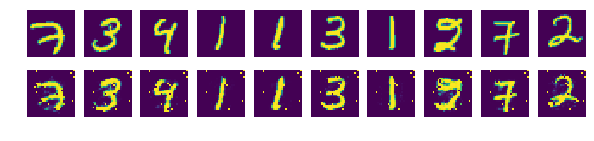

In [6]:
sample_size = 10
samples = sess.run(decoder, feed_dict={X:train_imgs[:sample_size]})
print('Training data cost = ', '{:.4f}'.format(sess.run(cost, feed_dict={X:train_imgs[:sample_size]})))

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(train_imgs[i], (28,28))) #imshow : 이미지 출력함수
    ax[1][i].imshow(np.reshape(samples[i], (28,28)))

plt.show()

## 6.2 Testing data 결과확인

Testing data cost =  0.0440


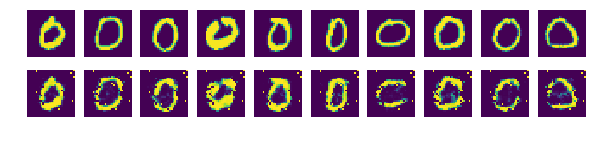

In [7]:
sample_size = 10
ADsamples = sess.run(decoder, feed_dict={X:test_imgs[:sample_size]})
print('Testing data cost = ', '{:.4f}'.format(sess.run(cost, feed_dict={X:test_imgs[:sample_size]})))

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(test_imgs[i], (28,28))) #imshow : 이미지 출력함수
    ax[1][i].imshow(np.reshape(ADsamples[i], (28,28)))

plt.show()